# Homework 2

Домашние задания являются полностью опциональными, оценки никуда не идут.

### Дедлайн: 05.07.20 (вс) 23:55 мск

### Формат сдачи

Заполненный ipynb файл с кодом

дополнительно добавьте:
* "checkpoint" файл из `torch.save(model.state_dict(), ...)` который содержит веса модели для задачи 1, 3 и поможет удостовериться в точности на валидации
* имеется возможность перезапустить весь ipynb файл, чтобы убедиться в финальном результате, например в 1й и 3й задаче (можете сделать конструкцию if else, н: если файл с весами присутствует, тогда показываем точность, иначе запускаем training рутину и выводим в конце точность)

# Задача 1 - Train your own model (60 баллов)

В этом задании вы построете сверточную нейросеть (CNN) для решения Tiny ImageNet классификации. Постарайтесь добиться максимальной точности на валидации.

### Оценивание

* За преодоление каждого порога даётся 10 баллов
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
    
### Ограничения

* __В первом пункте нельзя использовать предобученные нейросети.__ Сами архитектуры использовать можно.

### Советы

* Одно изменение в один момент времени
* Используйте GPU, постарайтесь написать device-agnostic код, чтобы нигде не присутствовало `.cuda()`, а было `.to(device)`
* Логируйте промежуточный результаты, например в TensorBoard
* С чем можно поиграться: optimizer, lr scheduler, архитектура, инициализации, loss, регуляризации (dropout, cutmix, weight decay, аугментации и тд), и кучу всего разного
* Про "фишечки", которые можно внедрить для улучшения качества, можно посмотреть здесь https://arxiv.org/abs/1812.01187
* Постарайтесь по максимуму переиспользовать написанный код, то есть реализовать в виде набора функций например тренировочную рутину и ее использовать в задаче 1, 2, 4
* Как обычно: читабельный, понятный код приветствуется

### Какую архитектуру выбрать для обучения?
* пишем сами
* берём готовую архитектуру (например отсюда https://github.com/rwightman/pytorch-image-models (очень классный ресурс с модными архитектурами) или отсюда https://pytorch.org/docs/stable/torchvision/models.html)

In [28]:
from __future__ import print_function
from __future__ import division
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import time
import os
import copy
import pickle
import numpy as np
import pandas as pd

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
CUDA is available!  Training on GPU ...


In [30]:
!nvidia-smi
torch.cuda.empty_cache()
torch.cuda.is_available()

Thu Jul  9 10:24:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050    On   | 00000000:01:00.0 Off |                  N/A |
| N/A   52C    P0    N/A /  N/A |    885MiB /  4040MiB |      8%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

In [31]:
# #загрузка может занять довольно длительное время (< 20 минут)
# import tiny_imagenet
# tiny_imagenet.download(".")

In [32]:
print(torchvision.__version__)

0.6.0


Тренировочные и валидационные данные лежат в `tiny-imagenet-200/train` и `tiny-imagenet-200/val`.

In [33]:
# put your code here

In [34]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [35]:
# Пути до датасетов изменены в соответвии с локальными
TRAIN_DIR = Path('/storage/Study/DBO/cv/cv-course-hse-summer-2020/hw2/tiny-imagenet-200/train/')
TEST_DIR = Path('/storage/Study/DBO/cv/cv-course-hse-summer-2020/hw2/tiny-imagenet-200/test/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.JPEG')))
test_files = sorted(list(TEST_DIR.rglob('*.JPEG')))

In [36]:
# train_val_files

In [37]:
# При загрузке данных в режиме train добавлены случайные трансформации
class TinyDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image
  
    def __getitem__(self, index):

        if self.mode == 'test':
          transform = transforms.Compose([
              transforms.ToTensor(),
            #   transforms.Normalize((0.5,), (0.5,))
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        elif self.mode == 'val':
          transform = transforms.Compose([
              transforms.ToTensor(),
            #   transforms.Normalize((0.5,), (0.5,))
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
          ])
        elif self.mode == 'train':
          transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.RandomHorizontalFlip(),
              transforms.RandomRotation(degrees = 20),
              transforms.RandomRotation(degrees = 20),
              transforms.RandomRotation(degrees = 10),
              transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.7, 1.0)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            # transforms.Normalize((0.5,), (0.5,))
          ])
          
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [38]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [39]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [40]:
val_dataset = TinyDataset(train_files, mode='val')

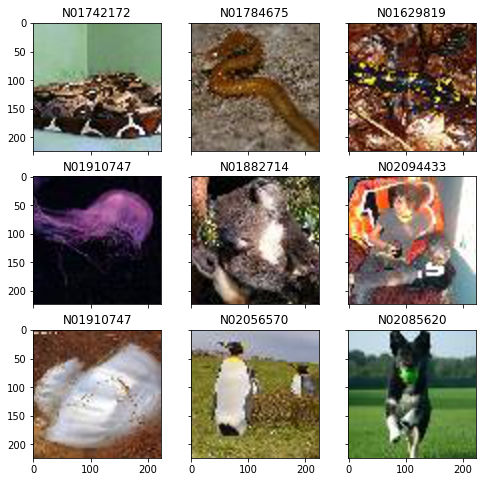

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 10000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [42]:
# val_dataset[1][0].shape
# train_dataset[1][0].shape

In [78]:
# Для ResNet учим слой класификатора и последний сверточный слой layer4 
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True


#   for param in model.parameters():
#       param.requires_grad = False
        
#   for param in model.layer4.parameters():
#       param.requires_grad = True
        

In [79]:
# используем  ResNet18
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.model_ft = models.resnet18(pretrained=False)
        set_parameter_requires_grad(self.model_ft)
        num_ftrs = self.model_ft.fc.in_features
        # self.model_ft.fc = nn.Linear(num_ftrs, num_ftrs)
        self.model_ft.fc = nn.Linear(num_ftrs, 200)

    def forward(self, x):
        logits = self.model_ft(x)
        return logits



In [80]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [81]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [98]:
# Используем подобранный StepLR
# Оптимизатор AdamW
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = StepLR(opt, step_size=1, gamma=0.5)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            scheduler.step()
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [83]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [84]:
len(np.unique(train_val_labels))

200

In [85]:
n_classes = len(np.unique(train_val_labels))
classes_number = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))

# убедимся что не напутали с размерностями и архитектурой
print(simple_cnn)

we will classify :200
SimpleCnn(
  (model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [86]:
# посмотрим какие параметры учим
params_to_update = simple_cnn.parameters()
print("Params to learn:")

params_to_update = []
for name,param in simple_cnn.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 model_ft.conv1.weight
	 model_ft.bn1.weight
	 model_ft.bn1.bias
	 model_ft.layer1.0.conv1.weight
	 model_ft.layer1.0.bn1.weight
	 model_ft.layer1.0.bn1.bias
	 model_ft.layer1.0.conv2.weight
	 model_ft.layer1.0.bn2.weight
	 model_ft.layer1.0.bn2.bias
	 model_ft.layer1.1.conv1.weight
	 model_ft.layer1.1.bn1.weight
	 model_ft.layer1.1.bn1.bias
	 model_ft.layer1.1.conv2.weight
	 model_ft.layer1.1.bn2.weight
	 model_ft.layer1.1.bn2.bias
	 model_ft.layer2.0.conv1.weight
	 model_ft.layer2.0.bn1.weight
	 model_ft.layer2.0.bn1.bias
	 model_ft.layer2.0.conv2.weight
	 model_ft.layer2.0.bn2.weight
	 model_ft.layer2.0.bn2.bias
	 model_ft.layer2.0.downsample.0.weight
	 model_ft.layer2.0.downsample.1.weight
	 model_ft.layer2.0.downsample.1.bias
	 model_ft.layer2.1.conv1.weight
	 model_ft.layer2.1.bn1.weight
	 model_ft.layer2.1.bn1.bias
	 model_ft.layer2.1.conv2.weight
	 model_ft.layer2.1.bn2.weight
	 model_ft.layer2.1.bn2.bias
	 model_ft.layer3.0.conv1.weight
	 model_ft.layer3.0.bn

In [87]:
!nvidia-smi
import torch
torch.cuda.empty_cache()
torch.cuda.is_available()

Thu Jul  9 13:13:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050    On   | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0    N/A /  N/A |   3450MiB /  4040MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

In [88]:
  train_val_labels = [path.parent.parent.name for path in train_val_files]
  train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
  val_dataset = TinyDataset(val_files, mode='val')
  train_dataset = TinyDataset(train_files, mode='train')

In [91]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=12, batch_size=64) 

epoch:   8%|▊         | 1/12 [15:53<2:54:52, 953.82s/it]
Epoch 001 train_loss: 3.9771     val_loss 3.8397 train_acc 0.1437 val_acc 0.1663
loss 3.852376626001994
epoch:  17%|█▋        | 2/12 [31:28<2:38:01, 948.17s/it]
Epoch 002 train_loss: 3.8524     val_loss 3.7411 train_acc 0.1622 val_acc 0.1828
loss 3.760183734741211
epoch:  25%|██▌       | 3/12 [47:35<2:23:04, 953.86s/it]
Epoch 003 train_loss: 3.7602     val_loss 3.6490 train_acc 0.1778 val_acc 0.1960
loss 3.674564849319458
epoch:  33%|███▎      | 4/12 [1:03:35<2:07:23, 955.49s/it]
Epoch 004 train_loss: 3.6746     val_loss 3.6987 train_acc 0.1895 val_acc 0.2002
loss 3.3944138546244305
epoch:  42%|████▏     | 5/12 [1:19:57<1:52:25, 963.62s/it]
Epoch 005 train_loss: 3.3944     val_loss 3.3780 train_acc 0.2360 val_acc 0.2456
loss 3.3106945337168376
epoch:  50%|█████     | 6/12 [1:36:31<1:37:15, 972.66s/it]
Epoch 006 train_loss: 3.3107     val_loss 3.2665 train_acc 0.2492 val_acc 0.2555
loss 3.24906494585673
epoch:  58%|█████▊    | 7/1

In [94]:
loss, acc, val_loss, val_acc = zip(*history)

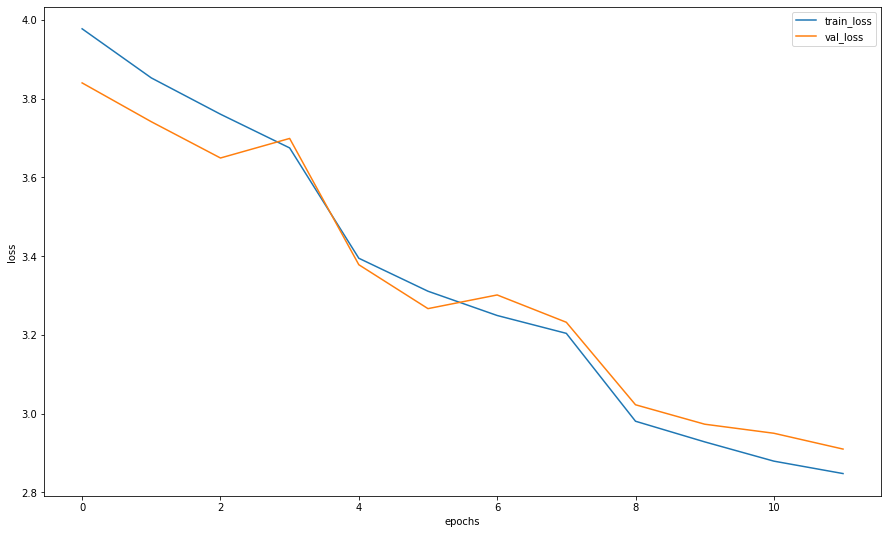

In [95]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Когда закончите обучение, сделайте отдельно инференс на валидации и выведите ниже результат.

In [97]:
_, val_accuracy = eval_epoch(simple_cnn, DataLoader(val_dataset, batch_size=32, shuffle=False), nn.CrossEntropyLoss())
print("Validation accuracy: %.2f%%" % (val_accuracy * 100))

Validation accuracy: 32.86%


In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=64) 

### Отчет

Кратако укажите, что вы попробывали, что получилось и дало прирост, а что нет

Сколько параметров у модели?

Как быстро она предсказывает класс для 1й картинки?

Oпцианально: выведите top-1, top-5 точность вашей модели

Опцианально: выведите картинки, на которых ваша модель сильнее всего ошибается (вероятность класса, соответствующая таргету, минимальная)

# Задача 2 - Transfer Learning (20 баллов)

Выберите любую предобученную модель. Сделайте transfer learning для датасета из задачи 1. Постарайтесь по-максимуму воспользоваться кодом из задачи 1, чтобы не дублировать его. Выведите точность на валидации.

In [ ]:
# Для ResNet учим слой класификатора и последний сверточный слой layer4 
def set_parameter_requires_grad(model):
    # for param in model.parameters():
    #     param.requires_grad = True


  for param in model.parameters():
      param.requires_grad = False
        
  for param in model.layer4.parameters():
      param.requires_grad = True
        

In [ ]:
# используем  ResNet18
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.model_ft = models.resnet18(pretrained=True)
        set_parameter_requires_grad(self.model_ft)
        num_ftrs = self.model_ft.fc.in_features
        # self.model_ft.fc = nn.Linear(num_ftrs, num_ftrs)
        self.model_ft.fc = nn.Linear(num_ftrs, 200)

    def forward(self, x):
        logits = self.model_ft(x)
        return logits



In [ ]:
n_classes = len(np.unique(train_val_labels))
classes_number = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))

# убедимся что не напутали с размерностями и архитектурой
print(simple_cnn)

In [60]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64) 

epoch:  10%|█         | 1/10 [13:33<2:02:03, 813.73s/it]
Epoch 001 train_loss: 4.1175     val_loss 3.4308 train_acc 0.1214 val_acc 0.2090
loss 3.2727558699035644
epoch:  20%|██        | 2/10 [23:02<1:38:41, 740.22s/it]
Epoch 002 train_loss: 3.2728     val_loss 3.1600 train_acc 0.2370 val_acc 0.2609
loss 2.9248201205952964
epoch:  30%|███       | 3/10 [32:27<1:20:12, 687.53s/it]
Epoch 003 train_loss: 2.9248     val_loss 2.9348 train_acc 0.3057 val_acc 0.3130
loss 2.8179295546213785
epoch:  40%|████      | 4/10 [41:50<1:05:01, 650.30s/it]
Epoch 004 train_loss: 2.8179     val_loss 2.7610 train_acc 0.3266 val_acc 0.3374
loss 2.6334965897115072
epoch:  50%|█████     | 5/10 [51:15<52:03, 624.75s/it]
Epoch 005 train_loss: 2.6335     val_loss 2.6805 train_acc 0.3671 val_acc 0.3562
loss 2.575456545689901
epoch:  60%|██████    | 6/10 [1:01:00<40:50, 612.74s/it]
Epoch 006 train_loss: 2.5755     val_loss 2.6443 train_acc 0.3780 val_acc 0.3654
loss 2.476345925623576
epoch:  70%|███████   | 7/10 [1:

In [62]:
loss, acc, val_loss, val_acc = zip(*history)

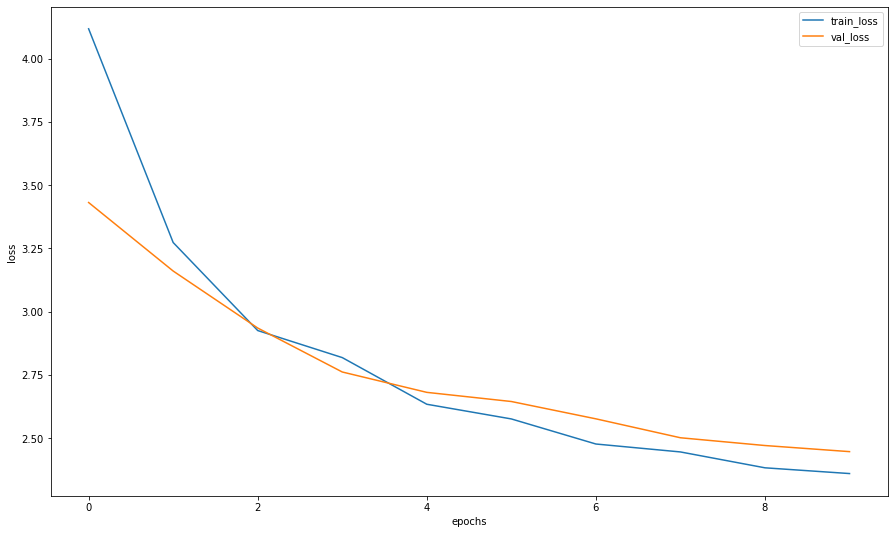

In [63]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Задача 3 - Grouped Convolutions (10 баллов)

Задача на понимание групповых сверток.

Стандартный вариант указать параметр __groups__  у `nn.Conv2d` и вызвать стандартный forward.

Попробуйте написать `forward` сами, воспользовавшись `torch.nn.functional.conv2d()` с одним ограничением, что параметр __groups__ в `torch.nn.functional.conv2d()` передавать нельзя.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def custom_forward(conv, x):
    # take convolution weights from conv.weight
    # put your code here

    return result

conv = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, groups=2, padding=1)
x = torch.rand(1, 8, 16, 16)
assert torch.allclose(conv(x), custom_forward(conv, x), rtol=1e-3)